# Test Reward Models on Other Datasets
*Written by Luke Chang*

This notebook contains code to test the Reward Models on all of the test datasets


# Load Modules, Functions, and Masks

In [32]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from nltools.data import Brain_Data, Design_Matrix
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import (zscore, 
                           regress, 
                           find_spikes, 
                           one_sample_permutation, 
                           _calc_pvalue, 
                           downsample, 
                           correlation_permutation, 
                           summarize_bootstrap, 
                           threshold, 
                           fdr
                          )
from nltools.analysis import Roc
from nltools.file_reader import onsets_to_dm
from nltools.external import glover_hrf
from nltools.utils import get_anatomical
from nilearn.plotting import view_img, glass_brain, plot_stat_map, plot_anat, plot_glass_brain, plot_epi
from tqdm import tqdm
import pingouin as pg 
import re
from scipy.stats import pearsonr, spearmanr
from fnl_tools.stats import global_zscore
from fnl_tools.plotting import rec_to_time
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import pairwise_distances
import plotly.express as px
from feat.plotting import plot_face, predict, load_viz_model
from pymer4.models import Lmer, Lm, Lm2
import warnings
warnings.filterwarnings('ignore')


def forced_choice_permutation_accuracy(data1, data2, model, tail=1, n_permutations=10000, metric='correlation'):
    '''Compute one-tailed p-values for forced choice accuracy using permutation test
    
    Args:
        data1: (Brain_Data) Brain_Data instance of Condition1(must be same subject order across conditions)
        data2: (Brain_Data) Brain_Data instance of Condition2 (must be same subject order across conditions)
        model: (Brain_Data) Brain_Data instance of model to test on each condition
        n_permutations: (int) Number of permutations to run, default 5,000
        
    Returns:
        dict: Dictionary with accuracy, one-tailed p-value, and null distribution
    '''
    
    if len(data1) != len(data1):
        raise ValueError('Conditions have a different number of subjects.')
        
    pexp = pd.DataFrame({'Condition1':data1.similarity(model, method=metric), 
                         'Condition2':data2.similarity(model, method=metric)})

    accuracy = np.mean(pexp['Condition1'] > pexp['Condition2'])

    null = []
    for iteration in range(n_permutations):
        null_iteration = []
        for i in range(len(pexp)):
            choice = np.random.choice([0,1])
            null_iteration.append(pexp.iloc[i, choice] > pexp.iloc[i, 1-choice])
        null.append(np.mean(null_iteration))

    return {'accuracy':accuracy, 'p':_calc_pvalue(null, accuracy, tail), 'null':null, 'pattern_similarity':pexp}


def plot_forced_choice_accuracy(data, line_color='lightgrey', line_width=2, line_style='-',
                                condition1_color='skyblue', condition2_color='navy',
                                point_size=8, labels=True, label_size=12, label_color='black',
                                ref_line=False, ref_line_style='--', ref_line_color='lightgrey',
                                text_gap=.005, vertical_gap=1, height_ratio=5, width_ratio=1.5):
    ''' Create a plot showing forced choice accuracy for each subject
    
    Args:
        line_color: (str) color of connecting line
        line_width: (int) width of connecting line
        line_style: (str) style of connecting line
        condition1_color: (str) color of marker for condition1
        condition2_color: (str) color of marker for condition2
        point_size: (int) size of marker
        labels: (bool) plot index as label
        label_size: (int) font size for label
        label_color: (str) font color for label
        ref_line: (bool) plot a reference line at x=0
        ref_line_style: (str) style for reference line
        ref_line_color: (str) color for reference line
        text_gap: (float) offset of text from point
        height_ratio: (float) scales figure height (i.e., distance between lines)
        width_ratio: (float) scales width of figure relative to height
        
    Returns:
        matplotlib object
    
    '''
    data.sort_values('Condition1', ascending=True, inplace=True)

    f,a = plt.subplots(figsize=(height_ratio*width_ratio, int(len(data)/height_ratio)))
    
    if ref_line:
        plt.axvline(0, linestyle=ref_line_style, color=ref_line_color)
    
    for i, idx in enumerate(data.iterrows()):
        row = idx[1]
        height = i/(len(data)/height_ratio)
#         height = ((i+)/((len(data)+1)/height_ratio))
        
        a.plot(row['Condition1'], height, color=condition1_color, marker='o', markersize=point_size)
        a.plot(row['Condition2'], height, color=condition2_color, marker='o', markersize=point_size)
        a.hlines(y=height, color=line_color, linestyle=line_style, linewidth=line_width,
                 xmax=max(row['Condition1'], row['Condition2']), 
                 xmin=min(row['Condition1'], row['Condition2']))
        
        if labels:
            a.annotate(int(row['Label']), xy=(min(row['Condition1'], row['Condition2'])-text_gap, height), 
                       horizontalalignment='right', verticalalignment='center',
                       size=label_size, color=label_color)
    
    a.get_yaxis().set_visible(False)
    a.set_xlim((min(data['Condition1'].min(), data['Condition2'].min() - text_gap - .05),
               max(data['Condition1'].max(), data['Condition2'].max() + text_gap + .05)))
    plt.tight_layout()
    
    
def plot_polar(data, n_top=3, overplot=False, palette='husl', 
               reorder=False, method='weighted', metric='correlation', labels=None,
               label_size=26, threshold=None, max_val=None,
               alpha_level=.8, legend=False, error_bars=None, line_width=4, line_alpha=.8):
    """ Make a polar plot
    data - Tabular data of shape features x classes with labels as index
    n_top - Number of features to select
    selection - Selection method to use `
                (top = M strongest for each class; std = N with greatest std across all)
    overplot - Overlap plots for each class?
    labels - Subset of features to use (overrides auto selection by n_top)
    palette - Color palette to use (can be label or list of colors from seaborn)
    reorder - If True, uses hierarchical clustering to reorder axis
    method - Method to use for clustering
    metric - Metric to use for clustering
    label_size - X axis label size
    threshold - Value to draw an optional line that denotes significance threshold
    max_val - Maximum value of y axis
    alpha_level - transparency value for lines
    legend - Show legend?
    error_bars - Option bootstrapped data to draw error bars
    line_width - width of lines
    line_alpha - alpha of lines
    """

    data = data.iloc[:n_top,:]
    n_panels = data.shape[1]
    
    if labels is not None:
        data = data.loc[labels,:]
    else:
        labels=data.index

    if error_bars is not None:
        error_bars = error_bars.loc[labels,:]

    if reorder is True:
        # Use hierarchical clustering to order
        from scipy.spatial.distance import pdist
        from scipy.cluster.hierarchy import linkage, leaves_list
        dists = pdist(data, metric=metric)
        pairs = linkage(dists, method=method)
        pairs[pairs < 0] = 0
        order = leaves_list(pairs)
        data = data.iloc[order,:]

        if error_bars is not None:
            error_bars = error_bars.iloc[order,:]

        labels = [labels[i] for i in order]


    theta = np.linspace(0.0, 2 * np.pi, len(labels), endpoint=False)
    
    ## Add first
    theta = np.concatenate([theta, [theta[0]]])
    if overplot:
        fig, ax = plt.subplots(1, 1, subplot_kw=dict(polar=True))
        fig.set_size_inches(10, 10)
    else:
        fig, axes = plt.subplots(n_panels, 1, sharex=False, sharey=False,
                             subplot_kw=dict(polar=True))
        fig.set_size_inches((6, 6 * n_panels))
        
    if isinstance(palette, str):
        from seaborn import color_palette
        colors = color_palette(palette, n_panels)
    else:
        colors = palette

    for i in range(n_panels):
        if overplot:
            alpha = alpha_level
        else:
            ax = axes[i]
            alpha = alpha_level

        if max_val is None:
            if error_bars is not None:
                max_val = data.values.max() + error_bars.values.max() + data.values.max() * .02
            else:
                max_val = data.values.max()
        
        ax.set_ylim(data.values.min(), max_val)
        
        d = data.iloc[:,i].values
        d = np.concatenate([d, [d[0]]])
        name = data.columns[i]

        if error_bars is not None:
            e = error_bars.iloc[:,i].values
            e = np.concatenate([e, [e[0]]])
        else:
            e = None

        if error_bars is not None:
            ax.errorbar(theta, d, yerr=e, capsize=0, color=colors[i], elinewidth = 3, linewidth=0)
        else:
            ax.plot(theta, d, alpha=line_alpha - 0.1, color=colors[i], linewidth=line_width, label=name)
            ax.fill(theta, d, ec='k', alpha=alpha, color=colors[i], linewidth=line_width)

        ax.set_xticks(theta)
        ax.set_rlabel_position(11.12)
        ax.set_xticklabels(np.concatenate([labels,[labels[0]]]), fontsize=label_size)
        [lab.set_fontsize(12) for lab in ax.get_yticklabels()]

    
    if threshold is not None:
        theta = np.linspace(0.0, 2 * np.pi, 999, endpoint=False)
        theta = np.concatenate([theta, [theta[0]]])
        d = np.array([threshold] * 1000)
        ax.plot(theta, d, alpha=1, color='black', linewidth=2, linestyle='--')

    if legend is True:
        ax.legend(bbox_to_anchor=(1.15, 1.1))

    plt.tight_layout()

    return labels, data


def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )

    
def time_stamp_to_tr(time_stamp, tr=2.0):
    '''Convert Min:Sec string timestamp into TRs'''
    if ':' not in time_stamp:
        raise ValueError('Time Stamp must be in the format Min:Sec')

    if len(time_stamp.split(':')) != 2:
        raise ValueError('Time Stamp must be in the format Min:Sec')
    minutes, seconds = time_stamp.split(':')
    return int((int(minutes)*60 + int(seconds))/tr)


def compute_loss_aversion_accuracy(data, n_permutations=10000, tail=1):
    '''Compute Forced Choice Accuracy for Loss Aversion Data using CSV file'''

    sub_list = data['Subject'].unique()
    loss_aversion_similarity = []
    for sub in sub_list:
        loss_aversion_similarity.append({'Subject':sub,
         'Accept':data.loc[(data['Subject'] == sub) & (data['Decision'] >= 1) & (data['Decision'] <= 2)]['Similarity'].mean(),
         'Reject':data.loc[(data['Subject'] == sub) & (data['Decision'] >= 3) & (data['Decision'] <= 4)]['Similarity'].mean()})
    loss_aversion_similarity = pd.DataFrame(loss_aversion_similarity)
    accuracy=(loss_aversion_similarity['Accept'] > loss_aversion_similarity['Reject']).mean()

    null = []
    for iteration in range(n_permutations):
        null_iteration = []
        for i in range(len(loss_aversion_similarity)):
            choice = np.random.choice([0,1])
            pexp = loss_aversion_similarity.iloc[i,1:]
            null_iteration.append(pexp.iloc[choice] > pexp.iloc[1-choice])
        null.append(np.mean(null_iteration))

    return {'accuracy':accuracy, 'p':_calc_pvalue(null, accuracy, tail), 'n':loss_aversion_similarity.shape[0], 'null':null, 'mean_diff':(loss_aversion_similarity['Accept'] - loss_aversion_similarity['Reject']).mean(), 'std_diff':(loss_aversion_similarity['Accept'] - loss_aversion_similarity['Reject']).std()}

zscore = lambda x: (x - np.mean(x, axis=0)) / np.std(x, axis=0)
center = lambda x: (x - np.mean(x, axis=0))

data_dir = '/Storage/Projects/Reward_Model'
hcp_dir = '/Storage/Data/HCP'
beta_dir = '/Storage/Data/social_deprivation/'
sweet_taste_path = '/Storage/Data/sweet_taste/derivatives/L1_Betas'
bart1_data_dir = '/Storage/Data/bart/derivatives/L1_Betas/smoothed_avg'
bart2_data_dir = '/Storage/Data/Neuropsychiatric_Phenomics_LA5c/'


# Load Maps

In [33]:
analysis_name = 'demeaned_zscore1_smooth0'

mask = Brain_Data(os.path.join(data_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

neurosynth_reward = Brain_Data(os.path.join(data_dir, 'Masks', 'reward_association-test_z_FDR_0.01.nii.gz'))
reward_mask = neurosynth_reward.smooth(5).threshold(upper=3.5, binarize=True)

reward_model = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_{analysis_name}_weightmap.nii.gz'))
reward_model_masked = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_masked_{analysis_name}_weightmap.nii.gz'))


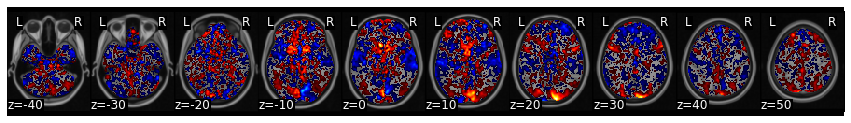

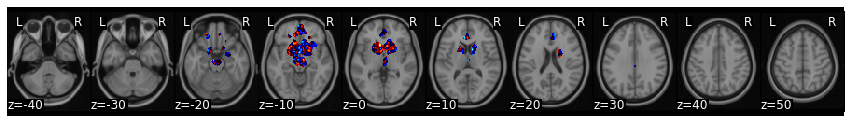

In [45]:
reward_model.plot()
reward_model_masked.plot()

# Construct Validity - Test All Datasets
This code tests all of the datasets and writes out relevant data for paper.

In [ ]:
def save_test_accuracy(analysis_name, reward_model):
    '''Compute Test Accuracy for out of sample Datasets and write to file'''
    
    print(f'\n{analysis_name}\n')
    
    def accuracy_summary(output, study='HCP_Reward_Test',contrast='Reward_vs_Punish'):
        return {'Study':study, 'Contrast':contrast,'Accuracy':output['accuracy'], 'p':output['p'], 'n':output['pattern_similarity'].shape[0], 'mean_diff':(output['pattern_similarity']['Condition1']-output['pattern_similarity']['Condition2']).mean(),'std_diff':(output['pattern_similarity']['Condition1']-output['pattern_similarity']['Condition2']).std()}

    # Initialize Output Variables
    accuracy_dict = {}
    all_accuracy = {}
    all_pattern_similarity = []

    
    # HCP Reward
    study = 'HCP_Reward_Test'
    contrast = 'Reward_vs_Punish'
    hcp_reward_test = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Reward_Test_n98.hdf5'))
    hcp_punish_test = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Punish_Test_n98.hdf5'))
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(hcp_reward_test, hcp_punish_test, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])

    # MID MIT
    study = 'MID_MIT'
    contrast = 'Reward_vs_NoReward'
    mid_mit_reward = glob.glob(os.path.join('/Storage', 'Data', 'social_deprivation', 'derivatives', 'L1_Betas','sub-*_task-midloc_Reward_beta_smooth6mm.nii.gz'))
    sort_nicely(mid_mit_reward)
    mid_mit_reward = Brain_Data(mid_mit_reward)
    mid_mit_noreward = glob.glob(os.path.join('/Storage', 'Data', 'social_deprivation', 'derivatives', 'L1_Betas','sub-*_task-midloc_NoReward_beta_smooth6mm.nii.gz'))
    sort_nicely(mid_mit_noreward)
    mid_mit_noreward = Brain_Data(mid_mit_noreward)
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(mid_mit_reward, mid_mit_noreward, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])

    # MID Vanderbilt
    study = 'MID_Vanderbilt'
    contrast = 'Reward_vs_NoReward'
    mid_duke_gain = Brain_Data(os.path.join(data_dir, 'Data', 'Trust_paper_datasets', 'D15_MID_Duke', 'Duke_MID_gain.nii.gz'))
    mid_duke_neutral = Brain_Data(os.path.join(data_dir, 'Data', 'Trust_paper_datasets', 'D15_MID_Duke', 'Duke_MID_neutral.nii.gz'))
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(mid_duke_gain, mid_duke_neutral, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])

    # Rutgers Social 2012
    study = 'Rutgers_Social'
    stranger_reward = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2012', 'Feedback_Summary', 'StrangerRew.hdf5'))
    stranger_punish = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2012', 'Feedback_Summary', 'StrangerPun.hdf5'))
    friend_reward = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2012', 'Feedback_Summary', 'FriendRew.hdf5'))
    friend_punish = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2012', 'Feedback_Summary', 'FriendPun.hdf5'))
    computer_reward = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2012', 'Feedback_Summary', 'CompRew.hdf5'))
    computer_punish = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2012', 'Feedback_Summary', 'CompPun.hdf5'))
    
    contrast = 'Friend_vs_Stranger_Reward'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(friend_reward, stranger_reward, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    contrast = 'Human_vs_Computer_Reward'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy((friend_reward+stranger_reward)/2, computer_reward, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    contrast = 'Reward_vs_Punish'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy((friend_reward+stranger_reward+computer_reward)/3, (friend_punish+stranger_punish+computer_punish)/3, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    # Rutgers Trust 2015
    study = 'Rutgers_Trust'
    stranger_reciprocate = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'StrangerReciprocateFB.hdf5'))
    stranger_defect = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'StrangerDefectFB.hdf5'))
    friend_reciprocate = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'FriendReciprocateFB.hdf5'))
    friend_defect = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'FriendDefectFB.hdf5'))
    computer_reciprocate = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'ComputerReciprocateFB.hdf5'))
    computer_defect = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'ComputerDefectFB.hdf5'))
    friend_reciprocate_n24 = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'FriendReciprocateFB_n24.hdf5'))
    friend_defect_n24 = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'FriendDefectFB_n24.hdf5'))
    stranger_reciprocate_n24 = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'StrangerReciprocateFB_n24.hdf5'))
    stranger_defect_n24 = Brain_Data(os.path.join(data_dir, 'Data', 'Fareri_2015', 'Feedback_Summary', 'StrangerDefectFB_n24.hdf5'))

    contrast = 'Friend_vs_Stranger_Reciprocate'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(friend_reciprocate, stranger_reciprocate, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    contrast = 'Human_vs_Computer_Reciprocate'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy( ((friend_reciprocate_n24 + stranger_reciprocate_n24)/2), computer_reciprocate, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    contrast = 'Reciprocate_vs_Defect'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(((friend_reciprocate_n24 + stranger_reciprocate_n24 + computer_reciprocate)/3), ((friend_defect_n24 + stranger_defect_n24 + computer_defect)/3), reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])

    # Neurosynth Gene - Dopamine
    dopamine = Brain_Data(os.path.join(data_dir, 'Data','NeurosynthGene','Dopamine_Genes.nii.gz'))
    dopamine_similarity = dopamine.similarity(reward_model, method='correlation')
    dopamine_similarity = pd.DataFrame(dopamine_similarity, columns=['Similarity'], index=['D1','D2','D3','D4','D5'])
    dopamine_similarity.sort_index(ascending=False, inplace=True)
    all_accuracy['NeurosynthGene_D1'] = {'Study':'NeurosynthGene', 'Contrast':'D1_Similarity','Accuracy':dopamine_similarity.loc['D1', 'Similarity'], 'p':np.nan}
    all_accuracy['NeurosynthGene_D2'] = {'Study':'NeurosynthGene', 'Contrast':'D2_Similarity','Accuracy':dopamine_similarity.loc['D2', 'Similarity'], 'p':np.nan}
    all_accuracy['NeurosynthGene_D3'] = {'Study':'NeurosynthGene', 'Contrast':'D3_Similarity','Accuracy':dopamine_similarity.loc['D3', 'Similarity'], 'p':np.nan}
    all_accuracy['NeurosynthGene_D4'] = {'Study':'NeurosynthGene', 'Contrast':'D4_Similarity','Accuracy':dopamine_similarity.loc['D4', 'Similarity'], 'p':np.nan}
    all_accuracy['NeurosynthGene_D5'] = {'Study':'NeurosynthGene', 'Contrast':'D5_Similarity','Accuracy':dopamine_similarity.loc['D5', 'Similarity'], 'p':np.nan}

    # Fallypride D2
    file_list = glob.glob(os.path.join('/Storage', 'Data', 'castrellon_dopamine','sub-*','pet', '*bpnd_space-MNI152.nii.gz'))
    file_list.sort()
    d2 = Brain_Data(file_list)
    d2_similarity = d2.similarity(reward_model)
    d2_stats = one_sample_permutation(d2_similarity)
    all_accuracy['Fallypride_D2'] = {'Study':'HCP_Reward_Test', 'Contrast':'D2_Similarity','Accuracy':d2_stats['mean'], 'p':d2_stats['p'], 'n':len(d2_similarity)}

    # Sweet Taste
    study = 'Sweet_Taste'
    cal_0 = Brain_Data(os.path.join(sweet_taste_path, f'Sweet_Taste_0cal.hdf5'))
    cal_75 = Brain_Data(os.path.join(sweet_taste_path, f'Sweet_Taste_75cal.hdf5'))

    contrast = 'Calorie75_vs_Calorie0'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(cal_75, cal_0, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    # Milkshake
    study = 'Milkshake'
    milkshake_cue_files = glob.glob(os.path.join(data_dir, 'Data', 'Milkshake', '*', 'mkFX', 'con_0001.nii.gz'))
    milkshake_cue_files.sort()
    milkshake_cue = Brain_Data(milkshake_cue_files)

    water_cue_files = glob.glob(os.path.join(data_dir, 'Data', 'Milkshake', '*', 'mkFX', 'con_0002.nii.gz'))
    water_cue_files.sort()
    water_cue = Brain_Data(water_cue_files)

    milkshake_files = glob.glob(os.path.join(data_dir, 'Data', 'Milkshake', '*', 'mkFX', 'con_0003.nii.gz'))
    milkshake_files.sort()
    milkshake_taste = Brain_Data(milkshake_files)

    water_files = glob.glob(os.path.join(data_dir, 'Data', 'Milkshake', '*', 'mkFX', 'con_0004.nii.gz'))
    water_files.sort()
    water_taste = Brain_Data(water_files)

    contrast = 'Milkshake_vs_Water_Cue'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(milkshake_cue, water_cue, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])    
    
    contrast = 'Milkshake_vs_Water_Taste'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(milkshake_taste, water_taste, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])    
    
    # Bart 
    study = 'Bart'
    pump_files_s2 = glob.glob(os.path.join(bart2_data_dir, 'derivatives', 'L1_Betas', 'bart', 'smoothed',f'*_task-bart_pumps.nii.gz'))
    pump_files_s2.sort()
    risky_pumps_s2 = Brain_Data(pump_files_s2)

    control_files_s2 = glob.glob(os.path.join(bart2_data_dir, 'derivatives', 'L1_Betas', 'bart', 'smoothed',f'*_task-bart_control_pumps.nii.gz'))
    control_files_s2.sort()
    safe_pumps_s2 = Brain_Data(control_files_s2)

    explode_files_s2 = glob.glob(os.path.join(bart2_data_dir, 'derivatives', 'L1_Betas', 'bart', 'smoothed',f'*_task-bart_explode.nii.gz'))
    explode_files_s2.sort()

    cash_files_s2 = glob.glob(os.path.join(bart2_data_dir, 'derivatives', 'L1_Betas', 'bart', 'smoothed',f'*_task-bart_cash.nii.gz'))
    cash_files_s2.sort()
    explode_subs_s2 = [os.path.basename(x).split('_')[0] for x in explode_files_s2]
    cash_subs_s2 = [x for x in cash_files_s2 if os.path.basename(x).split('_')[0] in explode_subs_s2]

    explode_s2 = Brain_Data(explode_files_s2)
    cash_s2 = Brain_Data(cash_subs_s2)

    contrast = 'Cash_vs_Explode'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(cash_s2, explode_s2, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])    

    contrast = 'Risky_vs_Safe'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(risky_pumps_s2, safe_pumps_s2, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
   
    # HCP Social
    study = 'HCP_Social'
    contrast = 'Social_vs_Control'
    hcp_control = Brain_Data('/Storage/Data/HCP/Analyses/HCP_SOCIAL/HCP_SOCIAL_Random_n484.hdf5')
    hcp_social = Brain_Data('/Storage/Data/HCP/Analyses/HCP_SOCIAL/HCP_SOCIAL_TOM_n484.hdf5')
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(hcp_social, hcp_control, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])   
    
    # Self-Referencing
    study = 'Self_Referential'
    contrast = 'Self_vs_Font'
    self_chinese = Brain_Data(os.path.join(data_dir, 'Data', 'Trust_paper_datasets', 'D14_Other_self_font', 'self_chinese_data.nii.gz'))
    font_chinese = Brain_Data(os.path.join(data_dir, 'Data', 'Trust_paper_datasets', 'D14_Other_self_font', 'font_chinese_data.nii.gz'))
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(self_chinese, font_chinese, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])   

    # Pain - Chang 2015
    study = 'Boulder_Pain'
    contrast = 'High_vs_Low'
    high_list = glob.glob(os.path.join('/Storage/Data/chang2015_pain','*High*nii.gz'))
    sort_nicely(high_list)
    pain_high = Brain_Data(high_list)
    low_list = glob.glob(os.path.join('/Storage/Data/chang2015_pain','*Low*nii.gz'))
    sort_nicely(low_list)
    pain_low = Brain_Data(low_list)
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(pain_high, pain_low, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])   
    
    # IAPS - PINES
    study = 'Pittsburgh_IAPS'
    contrast = 'Negative_vs_Neutral'
    neg_pines = Brain_Data(os.path.join(data_dir, 'Data', 'Trust_paper_datasets', 'D5_affect_PINES', 'emotion_dat2_negative.nii.gz'))
    neu_pines = Brain_Data(os.path.join(data_dir, 'Data', 'Trust_paper_datasets', 'D5_affect_PINES', 'emotion_dat2_neutral.nii.gz'))
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(neg_pines, neu_pines, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])   

    # HCP Language
    study = 'HCP_Language'
    contrast = 'Story_vs_Math'
    hcp_math = Brain_Data('/Storage/Data/HCP/Analyses/HCP_LANGUAGE/HCP_LANGUAGE_Math_n484.hdf5')
    hcp_story = Brain_Data('/Storage/Data/HCP/Analyses/HCP_LANGUAGE/HCP_LANGUAGE_Story_n484.hdf5')
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(hcp_story, hcp_math, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])   

    # HCP WM
    study = 'HCP_WM'
    contrast = '2Back_vs_0Back'
    hcp_0back = Brain_Data('/Storage/Data/HCP/Analyses/HCP_WM/HCP_WM_0Back_n484.hdf5')
    hcp_2back = Brain_Data('/Storage/Data/HCP/Analyses/HCP_WM/HCP_WM_2Back_n484.hdf5')
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(hcp_2back, hcp_0back, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])   

    # Stop Signal
    study = 'Stop_Signal'
    contrast = 'Success_vs_Fail'
    sst_success = Brain_Data(os.path.join(data_dir, 'Data', 'Trust_paper_datasets', 'D11_Other_SST_SuccessFailure', 'sst_stop_data.nii.gz'))
    sst_fail = Brain_Data(os.path.join(data_dir, 'Data', 'Trust_paper_datasets', 'D11_Other_SST_SuccessFailure', 'sst_fail_data.nii.gz'))
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(sst_success, sst_fail, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])   
    
    # Tomova Deprivation    
    study = 'MIT_Deprivation'
    s_social = Brain_Data(os.path.join(data_dir, 'Data', 'social_isolation', f'MIT_Deprivation_Session_s_Images_Social.hdf5'))
    s_baseline = Brain_Data(os.path.join(data_dir, 'Data', 'social_isolation', f'MIT_Deprivation_Session_s_Images_Baseline.hdf5'))
    s_food = Brain_Data(os.path.join(data_dir, 'Data', 'social_isolation', f'MIT_Deprivation_Session_s_Images_Food.hdf5'))
    f_social = Brain_Data(os.path.join(data_dir, 'Data', 'social_isolation', f'MIT_Deprivation_Session_f_Images_Social.hdf5'))
    f_baseline = Brain_Data(os.path.join(data_dir, 'Data', 'social_isolation', f'MIT_Deprivation_Session_f_Images_Baseline.hdf5'))
    f_food = Brain_Data(os.path.join(data_dir, 'Data', 'social_isolation', f'MIT_Deprivation_Session_f_Images_Food.hdf5'))
    
    contrast = 'SocialSession_Social_vs_Baseline'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(s_social, s_baseline, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    contrast = 'SocialSession_Social_vs_Food'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(s_social, s_food, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    contrast = 'FoodSession_Food_vs_Baseline'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(f_food, f_baseline, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    contrast = 'FoodSession_Food_vs_Social'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(f_food, f_social, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    contrast = 'SocialSession_Social_vs_FoodSession_Social'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(s_social, f_social, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    contrast = 'FoodSession_Food_vs_SocialSession_Food'
    accuracy_dict[f'{study}_{contrast}'] = forced_choice_permutation_accuracy(f_food, s_food, reward_model)
    all_accuracy[f'{study}_{contrast}'] = accuracy_summary(accuracy_dict[f'{study}_{contrast}'], study=study, contrast=contrast)
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Study'] = study
    accuracy_dict[f'{study}_{contrast}']['pattern_similarity']['Contrast'] = contrast
    all_pattern_similarity.append(accuracy_dict[f'{study}_{contrast}']['pattern_similarity'])
    
    # Loss Aversion
    study = 'Loss_Aversion'
    contrast = 'Accept_vs_Reject'
    loss_aversion_metadata = pd.read_csv(os.path.join(data_dir, 'Analyses', 'Classification', f'Loss_Aversion_Similarity_{analysis_name}.csv'))
    loss_aversion_output_s1 = compute_loss_aversion_accuracy(loss_aversion_metadata)
    all_accuracy[study] = {'Study':study, 'Contrast':contrast, 
                                     'Accuracy':loss_aversion_output_s1['accuracy'],
                                     'p':loss_aversion_output_s1['p'],
                                     'n':loss_aversion_output_s1['n'],
                                     'mean_diff':loss_aversion_output_s1['mean_diff'],
                                     'std_diff':loss_aversion_output_s1['std_diff']}
        
    # Write out Accuracy & Pattern Similarity
    all_accuracy = pd.DataFrame(all_accuracy).T
    all_accuracy['ID'] = all_accuracy.index
    all_accuracy.to_csv(os.path.join(data_dir, 'Analyses','Classification', f'Classification_Accuracy_{analysis_name}.csv'), index=False)
    
    # Write out pattern similarity
    all_pattern_similarity = pd.concat(all_pattern_similarity)
    all_pattern_similarity['Contrast_Similarity'] = all_pattern_similarity['Condition1'] - all_pattern_similarity['Condition2']
    all_pattern_similarity.to_csv(os.path.join(data_dir, 'Analyses','Classification', f'Pattern_Similarity_{analysis_name}.csv'), index=False)

for analysis_name in tqdm(['demeaned_zscore1_smooth0', 'masked_demeaned_zscore1_smooth0']):
# for analysis_name in tqdm(['demeaned_zscore1_smooth0', 'masked_demeaned_zscore1_smooth0', 'occipitalmasked_demeaned_zscore1_smooth0']):
    reward_model = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_{analysis_name}_weightmap.nii.gz'))
    save_test_accuracy(analysis_name, reward_model)

    

  0%|          | 0/3 [00:00<?, ?it/s]


demeaned_zscore1_smooth0



# Create Construct Validity Plots

## Plot Accuracy for Whole-Brain Reward Model

In [5]:
analysis_name = 'demeaned_zscore1_smooth0'

accuracy = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Classification_Accuracy_{analysis_name}.csv'))
pattern_similarity = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Pattern_Similarity_{analysis_name}.csv'))

accuracy[['Study', 'Contrast', 'n', 'mean_diff', 'std_diff', 'Accuracy', 'p']]

,Study,Contrast,n,mean_diff,std_diff,Accuracy,p
0,HCP_Reward_Test,Reward_vs_Punish,98.0,0.043374,0.019165,0.989796,0.000100
1,MID_MIT,Reward_vs_NoReward,23.0,0.082439,0.041689,1.000000,0.000100
2,MID_Vanderbilt,Reward_vs_NoReward,70.0,0.027424,0.030907,0.857143,0.000100
3,Rutgers_Social,Friend_vs_Stranger_Reward,20.0,-0.004930,0.027069,0.350000,0.946105
4,Rutgers_Social,Human_vs_Computer_Reward,20.0,0.010482,0.036154,0.650000,0.137386
5,Rutgers_Social,Reward_vs_Punish,20.0,0.040674,0.033763,0.900000,0.000200
6,Rutgers_Trust,Friend_vs_Stranger_Reciprocate,26.0,0.006021,0.034961,0.538462,0.424658
7,Rutgers_Trust,Human_vs_Computer_Reciprocate,24.0,-0.002745,0.034840,0.458333,0.717928
8,Rutgers_Trust,Reciprocate_vs_Defect,24.0,0.031185,0.024190,0.916667,0.000100
9,NeurosynthGene,D1_Similarity,NaN,NaN,NaN,0.039818,NaN


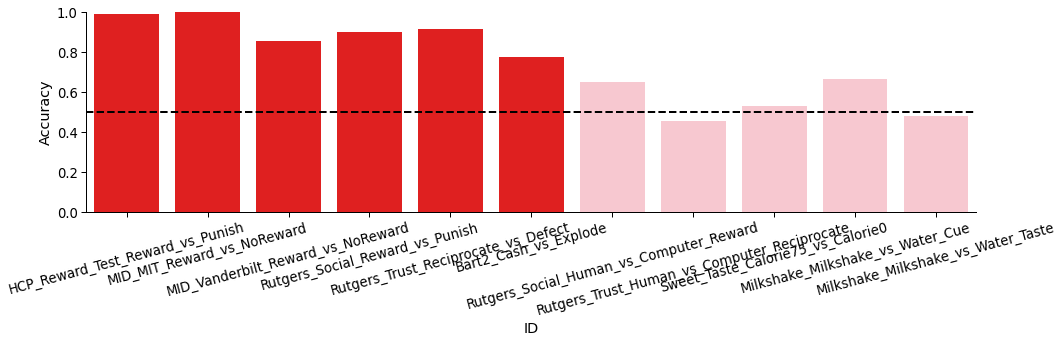

In [30]:
convergent_list = ['HCP_Reward_Test_Reward_vs_Punish',
                    'MID_MIT_Reward_vs_NoReward',
                    'MID_Vanderbilt_Reward_vs_NoReward',
                    'Rutgers_Social_Reward_vs_Punish',
                    'Rutgers_Trust_Reciprocate_vs_Defect',
                    'Bart2_Cash_vs_Explode',
                    'Rutgers_Social_Human_vs_Computer_Reward',
                    'Rutgers_Trust_Human_vs_Computer_Reciprocate',
                    'Sweet_Taste_Calorie75_vs_Calorie0',
                    'Milkshake_Milkshake_vs_Water_Cue',
                    'Milkshake_Milkshake_vs_Water_Taste']

convergent_accuracy = accuracy.loc[accuracy['ID'].isin(convergent_list)]

with sns.plotting_context(context='paper', font_scale=1.5):
    colors = ['red']*6 + ['pink']*6

    g = sns.catplot(data=convergent_accuracy, x='ID', y='Accuracy', kind='bar', aspect=3, 
                   palette=sns.color_palette(colors), order=convergent_list)
    plt.axhline(.5, color='black', linestyle='--', linewidth=2)
    plt.ylim([0,1])
    g.set_xticklabels(rotation=15)
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures',f'Reward_Model_{analysis_name}_Convergent_Test_Accuracy.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures',f'Reward_Model_{analysis_name}_Convergent_Test_Accuracy.pdf'))   

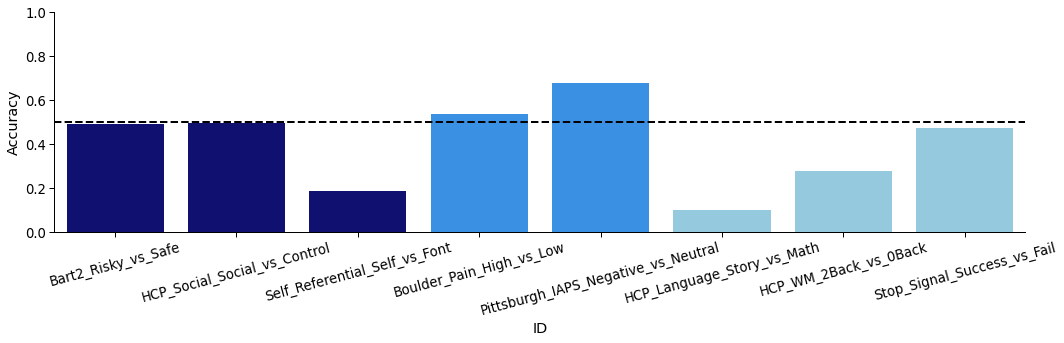

In [29]:
divergent_list = ['Bart2_Risky_vs_Safe',
                    'HCP_Social_Social_vs_Control',
                    'Self_Referential_Self_vs_Font',
                    'Boulder_Pain_High_vs_Low',
                    'Pittsburgh_IAPS_Negative_vs_Neutral',
                    'HCP_Language_Story_vs_Math',
                    'HCP_WM_2Back_vs_0Back',
                    'Stop_Signal_Success_vs_Fail']

divergent_accuracy = accuracy.loc[accuracy['ID'].isin(divergent_list)]

with sns.plotting_context(context='paper', font_scale=1.5):
    colors = ['navy']*3 + ['dodgerblue']*2 + ['skyblue']*3

    g = sns.catplot(data=divergent_accuracy, x='ID', y='Accuracy', kind='bar', aspect=3, 
                   palette=sns.color_palette(colors), order=divergent_list)
    plt.axhline(.5, color='black', linestyle='--', linewidth=2)
    plt.ylim([0,1])
    g.set_xticklabels(rotation=15)
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures',f'Reward_Model_{analysis_name}_Divergent_Test_Accuracy.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures',f'Reward_Model_{analysis_name}_Divergent_Test_Accuracy.pdf'))   

## Plot Accuracy for Masked Reward Model

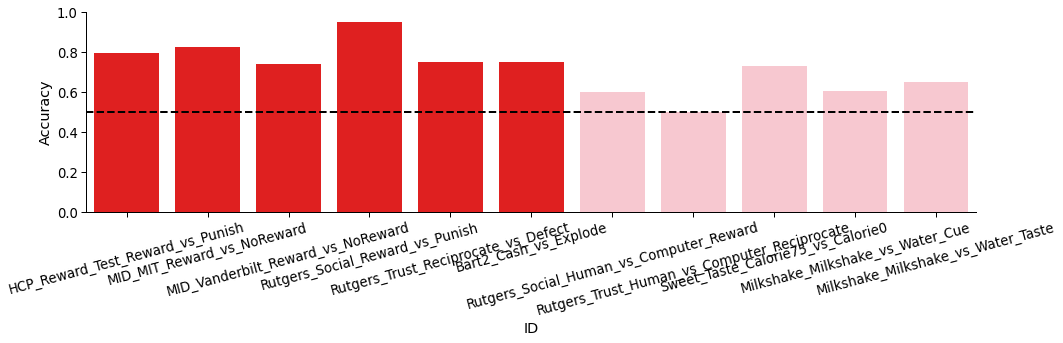

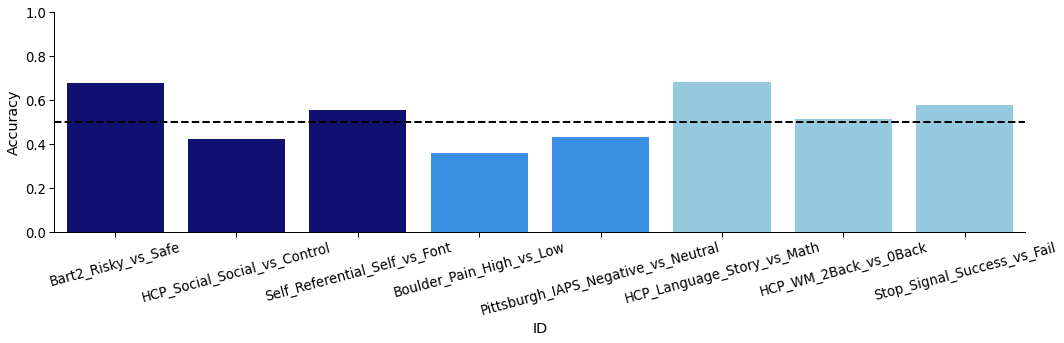

In [32]:
analysis_name = 'masked_demeaned_zscore1_smooth0'

accuracy = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Classification_Accuracy_{analysis_name}.csv'))
pattern_similarity = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Pattern_Similarity_{analysis_name}.csv'))
analysis_name = 'demeaned_zscore1_smooth0'

accuracy = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Classification_Accuracy_{analysis_name}.csv'))
pattern_similarity = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Pattern_Similarity_{analysis_name}.csv'))

accuracy[['Study', 'Contrast', 'n', 'mean_diff', 'std_diff', 'Accuracy', 'p']]

convergent_list = ['HCP_Reward_Test_Reward_vs_Punish',
                    'MID_MIT_Reward_vs_NoReward',
                    'MID_Vanderbilt_Reward_vs_NoReward',
                    'Rutgers_Social_Reward_vs_Punish',
                    'Rutgers_Trust_Reciprocate_vs_Defect',
                    'Bart2_Cash_vs_Explode',
                    'Rutgers_Social_Human_vs_Computer_Reward',
                    'Rutgers_Trust_Human_vs_Computer_Reciprocate',
                    'Sweet_Taste_Calorie75_vs_Calorie0',
                    'Milkshake_Milkshake_vs_Water_Cue',
                    'Milkshake_Milkshake_vs_Water_Taste']

convergent_accuracy = accuracy.loc[accuracy['ID'].isin(convergent_list)]

with sns.plotting_context(context='paper', font_scale=1.5):
    colors = ['red']*6 + ['pink']*6

    g = sns.catplot(data=convergent_accuracy, x='ID', y='Accuracy', kind='bar', aspect=3, 
                   palette=sns.color_palette(colors), order=convergent_list)
    plt.axhline(.5, color='black', linestyle='--', linewidth=2)
    plt.ylim([0,1])
    g.set_xticklabels(rotation=15)
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures',f'Reward_Model_{analysis_name}_Convergent_Test_Accuracy.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures',f'Reward_Model_{analysis_name}_Convergent_Test_Accuracy.pdf'))   
    
divergent_list = ['Bart2_Risky_vs_Safe',
                    'HCP_Social_Social_vs_Control',
                    'Self_Referential_Self_vs_Font',
                    'Boulder_Pain_High_vs_Low',
                    'Pittsburgh_IAPS_Negative_vs_Neutral',
                    'HCP_Language_Story_vs_Math',
                    'HCP_WM_2Back_vs_0Back',
                    'Stop_Signal_Success_vs_Fail']

divergent_accuracy = accuracy.loc[accuracy['ID'].isin(divergent_list)]

with sns.plotting_context(context='paper', font_scale=1.5):
    colors = ['navy']*3 + ['dodgerblue']*2 + ['skyblue']*3

    g = sns.catplot(data=divergent_accuracy, x='ID', y='Accuracy', kind='bar', aspect=3, 
                   palette=sns.color_palette(colors), order=divergent_list)
    plt.axhline(.5, color='black', linestyle='--', linewidth=2)
    plt.ylim([0,1])
    g.set_xticklabels(rotation=15)
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures',f'Reward_Model_{analysis_name}_Divergent_Test_Accuracy.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures',f'Reward_Model_{analysis_name}_Divergent_Test_Accuracy.pdf'))   

## Plot Neurosynth Gene Expression Images

In [27]:
neurosynth_gene = {'d1':28160,'d2':25204, 'd3':20900, 'd4':24323,'d5':16137}

d1 = Brain_Data(f'https://neurosynth.org/api/images/{neurosynth_gene["d1"]}/download.nii.gz')
d2 = Brain_Data(f'https://neurosynth.org/api/images/{neurosynth_gene["d2"]}/download.nii.gz')
d3 = Brain_Data(f'https://neurosynth.org/api/images/{neurosynth_gene["d3"]}/download.nii.gz')
d4 = Brain_Data(f'https://neurosynth.org/api/images/{neurosynth_gene["d4"]}/download.nii.gz')
d5 = Brain_Data(f'https://neurosynth.org/api/images/{neurosynth_gene["d5"]}/download.nii.gz')

dopamine = Brain_Data([d1,d2,d3,d4,d5])
dopamine.write(os.path.join(data_dir, 'Data','NeurosynthGene','Dopamine_Genes.nii.gz'))

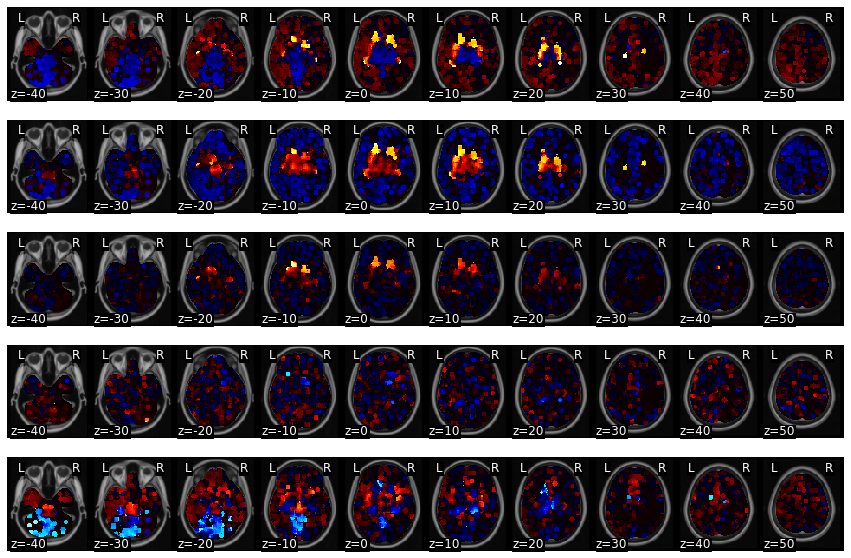

In [29]:
dopamine.plot()

<ipython-input-1-8df0569978d0>:230: MatplotlibDeprecationWarning: You have passed the 'edgecolor' kwarg before the 'color' kwarg.  Artist.set() currently reorders the properties to apply 'color' first, but this is deprecated since 3.3 and will be removed two minor releases later; please pass 'color' first instead.
  ax.fill(theta, d, ec='k', alpha=alpha, color=colors[i], linewidth=line_width)


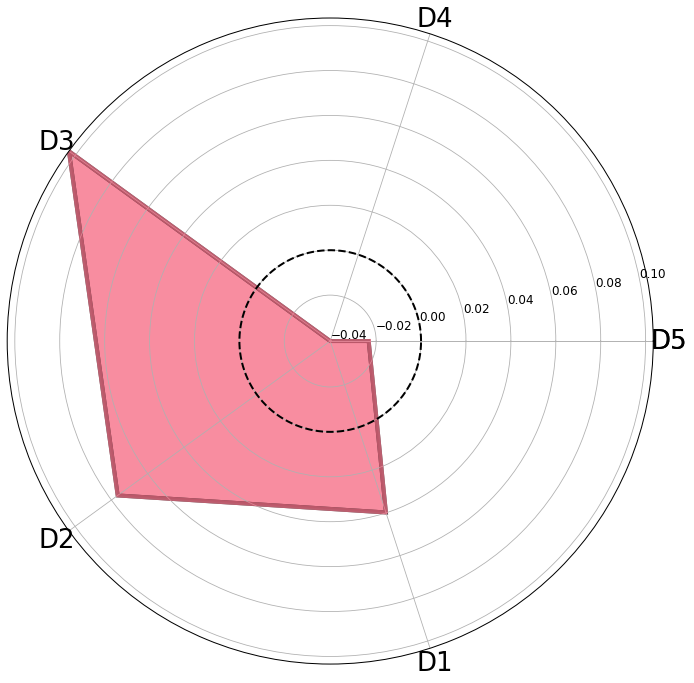

In [145]:
dopamine = Brain_Data(os.path.join(data_dir, 'Data','NeurosynthGene','Dopamine_Genes.nii.gz'))
dopamine_similarity = dopamine.similarity(reward_model, method='correlation')
dopamine_similarity = pd.DataFrame(dopamine_similarity, columns=['Similarity'], index=['D1','D2','D3','D4','D5'])
dopamine_similarity.sort_index(ascending=False, inplace=True)

with sns.plotting_context(context='paper', font_scale=2):
    plot_polar(dopamine_similarity, reorder=False, overplot=True, n_top=5, threshold=0 )
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures', f'NeurosynthGene_Dopamine_Pattern_Similarity_{analysis_name}.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', f'NeurosynthGene_Dopamine_Pattern_Similarity_{analysis_name}.pdf'))              

## Plot Castrellon D2 Fallypride PET Binding Potential Images

In [147]:
file_list = glob.glob(os.path.join('/Storage', 'Data', 'castrellon_dopamine','sub-*','pet', '*bpnd_space-MNI152.nii.gz'))
file_list.sort()
d2 = Brain_Data(file_list)
d2_similarity = d2.similarity(reward_model)

d2_stats = one_sample_permutation(d2_similarity)
print(f"Average D2 Binding Potential similarity: {d2_stats['mean']:.02}, p = {d2_stats['p']:.03}")

Average D2 Binding Potential similarity: 0.1, p = 0.0002


/home/ljchang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


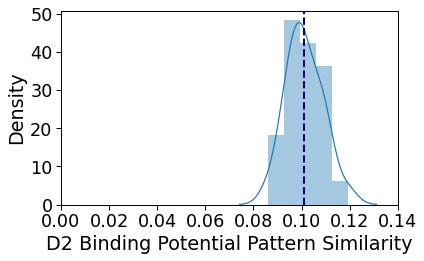

In [148]:
with sns.plotting_context(context='paper', font_scale=2):
    sns.distplot(d2_similarity)
    plt.axvline(d2_stats['mean'], color='navy', linestyle='--', linewidth=2)
    plt.xlim([0,0.14])
    plt.xlabel('D2 Binding Potential Pattern Similarity')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures',f'Duke_D2_BPND_Pattern_Similarity_{analysis_name}.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures',f'Duke_D2_BPND_Pattern_Similarity_{analysis_name}.pdf'))              

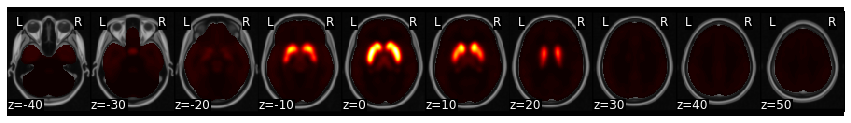

In [412]:
d2.mean().plot()

# Virtual Lesion Analysis
Compare Performance of Whole-brain vs Masked Reward Model using nested model comparisons implemented via mixed effects logistic regression

In [128]:
analysis_name = 'demeaned_zscore1_smooth0'

wholebrain_accuracy = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Classification_Accuracy_demeaned_zscore1_smooth0.csv'))
masked_accuracy = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Classification_Accuracy_masked_demeaned_zscore1_smooth0.csv'))
wholebrain_pattern_similarity = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Pattern_Similarity_demeaned_zscore1_smooth0.csv'))
masked_pattern_similarity = pd.read_csv(os.path.join(data_dir, 'Analyses','Classification', f'Pattern_Similarity_masked_demeaned_zscore1_smooth0.csv'))
wholebrain_pattern_similarity['Wholebrain_Accuracy'] = wholebrain_pattern_similarity['Contrast_Similarity'] > 0
masked_pattern_similarity['Masked_Accuracy'] = masked_pattern_similarity['Contrast_Similarity'] > 0
wholebrain_pattern_similarity['Masked_Accuracy'] = masked_pattern_similarity['Masked_Accuracy']
wholebrain_pattern_similarity['Condition'] = wholebrain_pattern_similarity['Study'] + '_' + wholebrain_pattern_similarity['Contrast']

conditions = wholebrain_pattern_similarity['Condition'].unique()

output=[]
for condition in conditions:
    condition_model_comparison =  wholebrain_pattern_similarity.query('Condition==@condition')
    condition_model_comparison['Subject'] = [x for x in range(len(condition_model_comparison))]
    model_comparison_long = condition_model_comparison.melt(id_vars=['Subject','Condition'], value_name='Accuracy', var_name='Model', value_vars=['Wholebrain_Accuracy','Masked_Accuracy'])
    model_comparison_long['Accuracy'] = model_comparison_long['Accuracy'].replace({True:1, False:0})
    model_decision = Lmer("Accuracy ~ Model + (Model |Subject)", data=model_comparison_long, family='binomial')
    model_decision.fit(verbose=False)

    output.append({'Study':condition,
        'Estimate':model_decision.coefs['Estimate']['ModelWholebrain_Accuracy'],
    'Z':model_decision.coefs['Z-stat']['ModelWholebrain_Accuracy'],
    'p':model_decision.coefs['P-val']['ModelWholebrain_Accuracy']})
output=pd.DataFrame(output)
output.to_csv(os.path.join(data_dir, 'Analyses','Classification','Model_Virtual_LesionAnalysis.csv'), index=False)
output['p_value'] = ['{:f}'.format(x) for x in output['p']]


unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: Accuracy~Model+(Model|Subject)

Family: binomial	 Inference: parametric

Number of observations: 196	 Groups: {'Subject': 98.0}

Log-likelihood: -51.178 	 AIC: 112.356

Random effects:

                             Name       Var     Std
Subject               (Intercept)     0.368   0.606
Subject  ModelWholebrain_Accuracy  2515.905  50.159

                 IV1                       IV2  Corr
Subject  (Intercept)  ModelWholebrain_Accuracy   1.0

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Formula: Accuracy~Model+(Model|Subject)

Family: binomial	 Inference: parametric

Number of observations: 46	 Groups: {'Subject': 23.0}

Log-likelihood: -10.627 	 AIC: 31.254

Random effects:

                             Name    Var    Std
Subject               (Intercept)  0.000  0.000
Subject  ModelWholebrain_Accuracy  0.001  0.037

                 IV1    

boundary (singular) fit: see help('isSingular') 

Formula: Accuracy~Model+(Model|Subject)

Family: binomial	 Inference: parametric

Number of observations: 32	 Groups: {'Subject': 16.0}

Log-likelihood: -5.319 	 AIC: 20.639

Random effects:

                             Name       Var     Std
Subject               (Intercept)     0.000   0.000
Subject  ModelWholebrain_Accuracy  3010.081  54.864

                 IV1                       IV2 Corr
Subject  (Intercept)  ModelWholebrain_Accuracy     

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Formula: Accuracy~Model+(Model|Subject)

Family: binomial	 Inference: parametric

Number of observations: 32	 Groups: {'Subject': 16.0}

Log-likelihood: -7.607 	 AIC: 25.214

Random effects:

                             Name       Var     Std
Subject               (Intercept)     0.000   0.000
Subject  ModelWholebrain_Accuracy  3016.425  54.922

                 IV1                       IV2 Corr
Subject  (Intercept)  ModelWh

Formula: Accuracy~Model+(Model|Subject)

Family: binomial	 Inference: parametric

Number of observations: 60	 Groups: {'Subject': 30.0}

Log-likelihood: -38.386 	 AIC: 86.772

Random effects:

                             Name    Var    Std
Subject               (Intercept)  0.936  0.967
Subject  ModelWholebrain_Accuracy  0.081  0.285

                 IV1                       IV2  Corr
Subject  (Intercept)  ModelWholebrain_Accuracy   1.0

Fixed effects:

